In [1]:

import yaml
# from train_eval.trainer import Trainer
import torch
import torch.nn as nn
# import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "2"


In [15]:
traj = torch.randn(4,15,12,2)
traj_gt =  torch.randn(4,12,2)
masks=torch.zeros(4,12)

In [16]:
num_modes = traj.shape[1]
traj_gt_rpt = traj_gt.unsqueeze(1).repeat(1, num_modes, 1, 1)
lengths = torch.sum(1-masks, dim=1).long()
inds = lengths.unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, num_modes, 1, 2) - 1

traj_last = torch.gather(traj[..., :2], dim=2, index=inds).squeeze(2)
traj_gt_last = torch.gather(traj_gt_rpt, dim=2, index=inds).squeeze(2)

err = traj_gt_last - traj_last[..., 0:2]
err = torch.pow(err, exponent=2)
err = torch.sum(err, dim=2)
err = torch.pow(err, exponent=0.5)
_, inds = torch.min(err, dim=1)

In [27]:
indices

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False,  True,  True, False, False, False, False, False, False, False,
          True,  True,  True, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False],
        [False, False,  True, False,  True, False, False, False, False, False,
          True,  True, False,  True,  True]])

In [29]:
indices

tensor([[False, False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False],
        [False,  True,  True, False, False, False, False, False, False, False,
          True,  True,  True, False, False],
        [False, False, False, False, False, False, False,  True, False, False,
         False, False, False, False, False],
        [False, False,  True, False,  True, False, False, False, False, False,
          True,  True, False,  True,  True]])

In [28]:
indices= (err <= 1)
for i in range(len(inds)):
    # print(i,inds[i])
    indices[i,inds[i]]=True

In [31]:
from metrics.utils import min_ade,min_fde_selection
mask_bool=min_fde_selection(traj,traj_gt,masks,1.0)
mask_bool

tensor([[ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
          True,  True,  True,  True,  True],
        [ True, False, False,  True,  True,  True,  True,  True,  True,  True,
         False, False, False,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True],
        [ True,  True, False,  True, False,  True,  True,  True,  True,  True,
         False, False,  True, False, False]])

In [6]:
from models.library.sampler import TorchModalitySampler
test_sampler=TorchModalitySampler(2,1)
endpoints,confidences = test_sampler(test)
endpoints

tensor([[[1., 3.],
         [8., 8.]]])

In [4]:
fake_feat=torch.randn(4,8,8,10,device='cuda:0')
endpoints=endpoints.long()
for i in range(len(test)):
    feat = (fake_feat[i])[endpoints[i,:,0],endpoints[i,:,1]]
feat


tensor([[ 0.0434,  0.5265, -1.1014,  0.4699, -0.8214,  0.5127, -0.8310,  1.1630,
         -0.0290,  1.1185],
        [ 0.0434,  0.5265, -1.1014,  0.4699, -0.8214,  0.5127, -0.8310,  1.1630,
         -0.0290,  1.1185]], device='cuda:0')

In [17]:
fake_feat[-1,-1,-1]

tensor([ 0.0325,  0.7594, -1.2122,  0.0885, -0.3049, -0.9373, -2.0800,  0.3722,
         1.3051,  0.7324])

In [ ]:

kernel_size=3
channel=2
unfold = nn.Unfold(kernel_size=(kernel_size, kernel_size), dilation=1, padding=kernel_size//2, stride=(1, 1))


In [ ]:
a=unfold(test).permute(0,2,1)
b=a.view(a.shape[0],a.shape[1],channel,kernel_size**2)
for i,j in enumerate(a):
    print(j)

In [ ]:
def get_unfolded_feature(feature,kernel,mask):
    ## Input shape B,C,H,W
    channel=feature.shape[1]
    unfold = nn.Unfold(kernel_size=(kernel, kernel), dilation=1, padding=kernel//2, stride=(1, 1))
    unfolded_feature=unfold(feature).permute(0,2,1) ## B,Number of slided window, channel*Number of elements in every window
    # unfolded_feature=unfolded_feature.view(unfolded_feature.shape[0],unfolded_feature.shape[1],channel,kernel**2)
    current_node_feat=feature.view(feature.shape[0],channel,-1).permute(0,2,1)## B,Number of slided window, channel
    # unfolded_feature=(unfolded_feature*mask.unsqueeze(-1)).to_sparse()
    # current_node_feat=(current_node_feat*mask.unsqueeze(-1)).to_sparse()
    target_feat=[]
    source_feat=[]
    for idx,batch in enumerate(current_node_feat):
        source_feat.append(batch[mask[idx]])
        target_feat.append(unfolded_feature[idx][mask[idx]])
    return source_feat,target_feat
source_feat,target_feat=get_unfolded_feature(op,15,mask_map)

In [ ]:
from models.library.blocks import LayerNorm
deocde_block=nn.Sequential(
                nn.Linear(2*48+2,48),
                LayerNorm(48),
                nn.LeakyReLU(),
                nn.Linear(48,48//2),
                LayerNorm(48//2),
                nn.LeakyReLU(),
                nn.Linear(48//2,1)
            ).to(op.device)
softmax=nn.Softmax(dim=-1)
def concat_feat(source_feat,target_feat,diff,channel):
    diff=diff.unsqueeze(0).to(source_feat[0].device)
    connectivities=[]
    for idx,batch in enumerate(source_feat):
        target_batch=target_feat[idx].view(target_feat[idx].shape[0],channel,-1).permute(0,2,1)
        batch=batch.unsqueeze(-1).repeat(1,1,target_batch.shape[-2]).permute(0,2,1)
        concat_feat=torch.cat((batch,target_batch,diff.repeat(batch.shape[0],1,1)),dim=-1)
        connectivity=softmax(deocde_block(concat_feat).squeeze(-1))
        connectivities.append(connectivity)
    return connectivities
connectivities=concat_feat(source_feat,target_feat,diff,48)

In [ ]:
x_coord,y_coord=torch.meshgrid(torch.arange(15//2,-((15//2)+1),-1),
                                torch.arange(-(15//2),((15//2)+1),1))
diff=torch.cat([x_coord.unsqueeze(0),y_coord.unsqueeze(0)],dim=0)
diff=diff.view(2,-1).T
# diff

In [3]:
with open("/home/stanliu/code/pgp/PGP/configs/ram.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [ ]:
ds_type = cfg['dataset'] + '_' + cfg['agent_setting'] + '_' + cfg['input_representation']
# cfg
# cfg['encoder_args']
# cfg.keys()

In [5]:
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_raster")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 38.729 seconds.
Reverse indexing ...
Done reverse indexing in 13.7 seconds.


In [6]:
import train_eval.utils as u
for i,data in enumerate(trainer.tr_dl):
    torch.cuda.empty_cache()
    # Load data
    data = u.send_to_device(u.convert_double_to_float(data))
    data_test=data['inputs']
    gt_test=data['ground_truth']
    break


In [7]:
focal=trainer.losses[0]
ade=trainer.losses[1]
# dri_loss=trainer.losses[1]


In [ ]:
# data['ground_truth']['traj']
map_representation = data_test['map_representation'][0]
mask=data_test['map_representation'][1]


mask.shape

In [ ]:
import torch.nn as nn
unfold = nn.Unfold(kernel_size=(7, 7), dilation=1, padding=7//2, stride=(1, 1))
unfold(mask.unsqueeze(1)).shape

In [ ]:
from models.library.RasterSampler import *
sampler = Sampler(cfg['aggregator_args'],resolution=1.0,apply_mask=True)
nodes_2D=sampler.sample_goals(mask)
mask_under=sampler.sample_mask(mask)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(255*test_htmap[0,:3].permute(1,2,0)*mask)
plt.show()
plt.imshow(x)
plt.show()
plt.imshow(map_representation[0].permute(1,2,0))
plt.show()
plt.imshow(mask.squeeze(-1))
plt.show()

In [ ]:
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()
def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window
window=create_window(7, 12)
gaussian(7, 1)
test_heatmap=F.conv2d(test_htmap, window, padding = 7//2, groups = 12)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_test['surrounding_agent_representation'][4,:3].permute(1,2,0))
plt.show()
# plt.imshow(test_heatmap[0,0])
# plt.show()
# data['ground_truth']['traj']

In [8]:
data_test['map_representation'].keys()

dict_keys(['lane_node_feats', 'lane_node_masks', 's_next', 'edge_type'])

In [9]:
print('lane_node_feats has shape of ',data_test['map_representation']['lane_node_feats'].shape)
print('lane_node_masks has shape of ',data_test['map_representation']['lane_node_masks'].shape)
print('s_next has shape of ',data_test['map_representation']['s_next'].shape)
print('edge_type has shape of ',data_test['map_representation']['edge_type'].shape)

lane_node_feats has shape of  cuda:0
lane_node_masks has shape of  torch.Size([6, 164, 20, 6])
s_next has shape of  torch.Size([6, 164, 15])
edge_type has shape of  torch.Size([6, 164, 15])


In [8]:
from torch.autograd.profiler import profile, record_function
with profile( profile_memory=True, record_shapes=True) as prof:
    encodings=trainer.model.encoder(data_test)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         2.27%       6.699ms         2.27%       6.699ms      37.637us           0 b           0 b     481.61 Mb     481.61 Mb           178  
                    aten::resize_         0.27%     795.788us         0.27%     795.788us      15.304us           0 b           0 b      88.06 Mb      88.06 Mb            52  
              aten::empty_strided         0.52%       1.531ms         0.52%       1.531ms     306.272us     930.25 Kb  

In [9]:
with profile( profile_memory=True, record_shapes=True) as prof:
    agg_feat=trainer.model.aggregator(encodings)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

# connectivities=agg_feat['node_connectivity']
# mask_map=agg_feat['under_sampled_mask']
# init=agg_feat['initial_states']
# print(connectivities.requires_grad)
# print(mask_map.requires_grad)

--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       aten::empty        14.71%      23.142ms        14.71%      23.142ms      91.834us           0 b           0 b       2.80 Gb       2.80 Gb           252  
                                     aten::resize_         4.17%       6.556ms         4.17%       6.556ms      50.048us     234.47 Kb     234.47 Kb       2.70 Gb       2.70 Gb           131  
                               ate

In [7]:
print(agg_feat.keys())
print(agg_feat['node_connectivity'].shape)
# print((agg_feat['initial_states'].indices().nelement() * agg_feat['initial_states'].indices().element_size() + agg_feat['initial_states'].values().nelement() *agg_feat['initial_states'].values().element_size()) / 1024**2)

dict_keys(['node_connectivity', 'under_sampled_mask', 'initial_states', 'feature', 'target_encodings'])
torch.Size([4, 5325, 5325])


In [ ]:
# test_feat=op.view(op.shape[0],op.shape[1],-1).permute(0,2,1)
torch.cuda.empty_cache()


In [ ]:
def pad_sp_tensor(test_feat,mask_map):
    max_num=max(mask_map.sum(dim=1))
    device=test_feat.device
    attn_masks=[]
    image_batch = []
    init_states=[]
    init_pos=torch.zeros([122,122],device=device)
    init_pos[100,61]=1
    for i,batch in enumerate(test_feat):
        init_state=((init_pos.view(-1))[mask_map[i]]).to_sparse()
        aug_state=torch.cat((init_state, torch.sparse_coo_tensor(torch.empty([1,0]), [], [max_num - init_state.size(0),],device=device)), 0).unsqueeze(0)
        init_states.append(aug_state)
        valid_nodes=batch[mask_map[i]].to_sparse(1)
        aug_nodes=torch.cat((valid_nodes, torch.sparse_coo_tensor(torch.empty([1,0]), torch.empty([0,valid_nodes.size(1)]), [max_num - init_state.size(0),valid_nodes.size(1)],device=device)), 0).unsqueeze(0)
        image_batch.append(aug_nodes)
        node_mask=torch.zeros([1,max_num],device=device)
        node_mask[:,valid_nodes.size(0):]=1
        attn_mask=(node_mask.byte()+node_mask.byte().T)
        attn_masks.append(attn_mask.unsqueeze(0).repeat(2,1,1))
    return torch.cat(image_batch,dim=0).to(device),torch.cat(attn_masks,dim=0).to(device),torch.cat(init_states,dim=0).to(device)

In [10]:

with profile( profile_memory=True, record_shapes=True) as prof:
    predictions=trainer.model.decoder(agg_feat)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))
# print(predictions['pred'].element_size() * predictions['pred'].nelement()/ 1024**2)
# pred=predictions['pred'].to_sparse()
# print(pred.element_size() * pred.nelement()/ 1024**2)

# print((pred.indices().nelement() * pred.indices().element_size() + pred.values().nelement() * pred.values().element_size()) / 1024**2)

/home/stanliu/code/pgp/PGP/models/library/sampler.py:46: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  coords = (agg == agg_max).nonzero()[0]


--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::resize_         6.56%       3.808ms         6.56%       3.808ms       8.120us     469.12 Kb     469.12 Kb      12.58 Mb      12.58 Mb           469  
                               aten::empty_strided         1.04%     602.138us         1.04%     602.138us      19.424us     174.56 Kb     174.56 Kb       1.32 Mb       1.32 Mb            31  
                                  

In [7]:
inputs = agg_feat
attn_output_weights = inputs['node_connectivity']
init_states=inputs['initial_states']


mask=inputs['under_sampled_mask']
target_encodings = inputs['target_encodings']
map_feature=inputs['feature'].permute(0,2,3,1)

In [8]:
torch.cuda.empty_cache()
predictions=torch.empty([init_states.shape[0],0,init_states.shape[-1]],device=attn_output_weights.device)
prev_states=init_states.unsqueeze(1).to_dense()

for step in range(12):
    predictions=torch.cat((predictions,torch.bmm(prev_states,attn_output_weights)),dim=1)
    prev_states=predictions[:,step].unsqueeze(1)

torch.cuda.empty_cache()

In [23]:
map_extent= [-61, 61, -22, 100]
from models.decoders.ram_decoder import get_dense,get_index
nodes_2D=get_index(predictions[:,-1].unsqueeze(1),mask)
dense_pred=get_dense(predictions[:,-1].unsqueeze(1),nodes_2D,122,122)
endpoints,confidences = trainer.model.decoder.endpoint_sampler(dense_pred)
endpoints=endpoints.long()
concat_feature=torch.empty([0,12,90],device=attn_output_weights.device)
x_coord,y_coord=torch.meshgrid(torch.arange(map_extent[-1],map_extent[-2],-1), ##### SHould be changed when image size changes
                                torch.arange(map_extent[0],map_extent[1],1))
indices=torch.cat([x_coord.unsqueeze(-1),y_coord.unsqueeze(-1)],dim=-1).to(attn_output_weights.device)
for batch_idx in range(len(dense_pred)):
    map_feat = (map_feature[batch_idx])[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]]
    diff = indices[endpoints[batch_idx,:,0],endpoints[batch_idx,:,1]].float()

    feature=torch.cat([map_feat,trainer.model.decoder.diff_encoder(diff),target_encodings[batch_idx].repeat(trainer.model.decoder.endpoint_sampler._n_targets,1)],dim=-1).unsqueeze(0)
    concat_feature=torch.cat([concat_feature,feature],dim=0)

In [ ]:
print(torch.cuda.memory_summary(0))

In [ ]:
pred=predictions['pred']
mask=predictions['mask']
traj_gt = gt_test['traj']

In [ ]:
import torch.nn.functional as F
with profile( profile_memory=True, record_shapes=True) as prof:
    swapped=torch.zeros_like(traj_gt).to(pred.device)
    swapped[:,:,0],swapped[:,:,1]=-traj_gt[:,:,1],traj_gt[:,:,0]
    coord=torch.round(swapped/trainer.losses[0].resolution+trainer.losses[0].compensation).int()
    coord=torch.clamp(coord,0,122)
    gt_map=torch.zeros([6,12,122,122],device=pred.device)
    for batch in range(6):
        for t in range(12):
            x,y=coord[batch,t]
            gt_map[batch,t,x,y]=1##Only one ground truth in each heatmap layer
    gs_map=F.conv2d(gt_map, trainer.losses[0].window, padding = trainer.losses[0].window_size//2, groups = trainer.losses[0].horizon)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss_mask = (reduced_gts == 1).float()
    pred_heatmap = torch.clamp(pred, min=1e-4)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    loss=-torch.sum(
                    torch.pow(pred_heatmap - reduced_maps, 2) * (
                    loss_mask * torch.log(pred_heatmap)
                    +
                    (1-loss_mask) * (torch.pow(1 - reduced_maps, 4) * torch.log(1 - pred_heatmap))
                )
            )
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
torch.cuda.empty_cache()
with profile( profile_memory=True, record_shapes=True) as prof:
    trainer.optimizer.step()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))


In [ ]:
with profile( profile_memory=True, record_shapes=True) as prof:
    gs_map=gs_map.view([6,12,-1])
    gt_map=gt_map.view([6,12,-1])
    max_num=max(mask.sum(dim=1))
    reduced_maps=[]
    reduced_gts=[]
    for i,batch in enumerate(gs_map):
        reduced_map=batch[mask[i].repeat(12,1)].view(12,-1)
        reduced_gt=gt_map[i][mask[i].repeat(12,1)].view(12,-1)
        aug_map=torch.cat((reduced_map, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        aug_gt=torch.cat((reduced_gt, torch.zeros(12,max_num - reduced_map.size(1),device=pred.device)), -1)
        reduced_maps.append(aug_map.unsqueeze(0))
        reduced_gts.append(aug_gt.unsqueeze(0))
    reduced_maps=torch.cat(reduced_maps,dim=0).to(pred.device)
    reduced_gts=torch.cat(reduced_gts,dim=0).to(pred.device)
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [29]:
reduced_gts.sum()

tensor(72., device='cuda:0')

In [ ]:
def get_index(pred,mask):
    x_coord,y_coord=torch.meshgrid(torch.arange(0,122,1),
                                torch.arange(0,122,1))
    nodes_candidates=torch.cat((x_coord.unsqueeze(0),y_coord.unsqueeze(0)),dim=0).view(2,-1).T
    nodes_2D=torch.zeros([mask.shape[0],pred.shape[-1],2])
    for i in range(mask.shape[0]):
        nodes_batch=nodes_candidates[mask[i]]
        nodes_2D[i,:nodes_batch.shape[0]]=nodes_batch
    return nodes_2D.int().permute(0,2,1).to(pred.device)
nodes_2D=get_index(pred,mask)
nodes_2D.shape

In [ ]:
def get_dense(pred,nodes_2D,H,W):
    dense_rep=torch.empty(0,pred.shape[1],H,W,device=pred.device)
    for batch in range(pred.shape[0]):
        batch_heatmap=torch.empty(0,H,W,device=pred.device)
        for step in range(pred.shape[1]):
            heatmap=torch.sparse_coo_tensor(nodes_2D[batch],pred[batch,step],(122,122))
            batch_heatmap=torch.cat((batch_heatmap,heatmap.to_dense().unsqueeze(0)),dim=0)
        dense_rep=torch.cat((dense_rep,batch_heatmap.unsqueeze(0)),dim=0)
    return dense_rep
dense_rep=get_dense(pred,nodes_2D,122,122)

In [12]:
predictions['probs']=predictions['prob']

In [13]:


with profile( profile_memory=True, record_shapes=True) as prof:

# loss=pred.sum()
    loss=focal.compute(predictions,gt_test)
    loss+=ade.compute(predictions,gt_test)
    loss.backward()
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 aten::empty         1.20%      26.132ms         1.20%      26.132ms      42.560us         512 b         512 b      12.70 Gb      12.70 Gb           614  
                               aten::resize_         0.44%       9.528ms         0.44%       9.528ms      54.756us         512 b         512 b       7.02 Gb       7.02 Gb           174  
                         aten::empty_strided         0.08%      

In [ ]:
trainer.model.aggregator

In [ ]:
pred = predictions['pred']
mask_da = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
ground_truth = gt_test
traj_gt = ground_truth['traj'] if type(ground_truth) == dict else ground_truth
true_heatmap,gs_map = focal.generate_gtmap(traj_gt,pred.shape)
gs_map=gs_map*mask_da
mask = (true_heatmap == 1).float()
pred_heatmap = torch.clamp(pred, min=1e-4)

In [ ]:
loss= focal()

In [ ]:
loss.backward()

In [ ]:
pred = predictions['pred']
mask = predictions['mask'].view(-1,pred.shape[-2],pred.shape[-1]).unsqueeze(1)
non_drivable_area_mask=~mask

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(non_drivable_area_mask[0,0].cpu())
plt.show()
plt.imshow(torch.zeros_like(non_drivable_area_mask[0,0].cpu()))
plt.show()

In [ ]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

In [ ]:
import torch
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1].type(torch.bool)
mask.shape

In [ ]:
idx=10
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))

In [ ]:

from torchvision.models import resnet34
# input = torch.cat((map_representation, surrounding_agent_representation), dim=1)
# resnet_model = resnet34(pretrained=False)
# conv1_new = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modules = list(resnet_model.children())[:-2]

# modules[0] = conv1_new
# backbone = nn.Sequential(*modules)
# data_test['target_agent_representation'].float().dtype

In [ ]:
from models.encoders.raster_encoder import *
encoder=RasterEncoder(cfg['encoder_args'])
# encodings=encoder.forward(data_test)

In [ ]:
encodings['context_encoding']["combined"].shape

In [ ]:
import torch
import torch.nn.modules as nn
fake_map_encodings=torch.randn(32, 512, 16,16)
fake_agent_input=torch.randn(32, 32).unsqueeze(2).unsqueeze(3).repeat(1,1,16,16)

In [ ]:
concatenated_encodings=torch.cat([fake_map_encodings,fake_agent_input],dim=1)
conv1d1=nn.Conv2d(544, 528, kernel_size=1, stride=1, bias=False)
conv1d2=nn.Conv2d(528, 512, kernel_size=1, stride=1, bias=False)
test_dim_reduction=nn.Sequential(conv1d1,nn.BatchNorm2d(528),nn.ReLU(),conv1d2,nn.BatchNorm2d(512),nn.ReLU())
fake_feature=test_dim_reduction(concatenated_encodings)
fake_feature=fake_feature.view(fake_feature.shape[0], fake_feature.shape[1], -1).permute(0, 2, 1)

fake_feature.shape

In [ ]:
upsampled_test=final_convs(transpose_convs(fake_feature))
# augmented_mask=mask.unsqueeze(-1)
print(upsampled_test[:,:,::2,::2].shape)


In [ ]:
import numpy as np


import torch
from torch import nn

# from model.decode import generic_decode

# from utils.image import gaussian_radius, draw_umich_gaussian

# from model.ConvGRU import ConvGRU

from einops import rearrange as rearr, repeat

from spatial_correlation_sampler import spatial_correlation_sample


class LocalWalk(nn.Module):
    def __init__(self, topk=0, radius=0.05, temp=0.05, pad_value=0,
            broadcast_val=False, corr_module=True):
        super(LocalWalk, self).__init__()

        self.topk = topk
        self.radius = radius
        self.vals = {}
        self.idxmaps = {}
        self.temp = temp
        self.pad_value = pad_value

        self.broadcast_val = broadcast_val

        self.corr_module = corr_module

    def get_identity_label(self, keys):
        '''
        returns 1 x H*W x H x W as reshaped H*W x H*W identity matrix
        '''
        B, C, H, W = keys.shape
        name = f"{H}_{W}"
        if name not in self.vals:
            vals = self.distance_field(H, W).flatten(0, 1)
            vals = (vals == 0).float() ##Returns an identity matrix, which is composed of multiple matrices.
            # The i th matrix has an element 1 at the i ith position, the rest places are all zeros.
            vals = repeat(vals, 'n h w -> b n h w', b=B if not self.broadcast_val else 1)## Repeat for batch number times
            self.vals[name] = vals.to(keys.device)
            print('created vals')

        return self.vals[name]

    def knn(self, A):
        if self.pad_value == 0 or self.topk > 0:
            with torch.no_grad():
                mask = (A == self.pad_value)
                if self.topk > 0:
                  mask |= (A < A.topk(k=self.topk, dim=-1)[0].min(-1, keepdim=True)[0])
            A[mask] = -10

        return A

    def distance_field(self, H, W, p=2):
        gx, gy = torch.meshgrid(torch.arange(0, H), torch.arange(0, W))
        D = ( (gx[None, None, :, :] - gx[:, :, None, None]).abs()**p + (gy[None, None, :, :] - gy[:, :, None, None]).abs()**p ).float() #** (1/p)
        return D

    def make_scatter_map(self, keys, kH, kW):
        B, C, H, W = keys.shape
        name = f"{H}_{W}_{kH}_{kW}"
        if name not in self.idxmaps:
            idx_map = torch.arange(H*W).view(H, W)[None, None].float()
            idx_map = torch.nn.functional.unfold(idx_map, kernel_size=(kH, kW), stride=1, padding=(kH//2, kW//2))
            idx_map = rearr(idx_map, 'b n hw -> b hw n')
            idx_map = idx_map.clamp(min=0).long()
            self.idxmaps[name] = idx_map.to(keys.device)
            print('created idx map')

        return self.idxmaps[name]

    def forward(self, query, keys, val=None):
        '''
        assumes q, k, v: B D N
        '''

        B, C, H, W = keys.shape
        kW = kH = int(H * self.radius) * 2 + 1

        val = self.make_scatter_map(keys, kH, kW)## Returns the indices of elements inside the sliding windows of all steps
        ## The sliding window has size (kH,kW), the input is keys.
        # out = self.get_identity_label(keys) * 0##Why all zeros?
        out = torch.zeros([B,H*W,H,W]).float()
        out = repeat(out, '1 n h w -> b (h w) n', b=B) if out.shape[0] == 1 else \
              rearr(out, 'b n h w -> b (h w) n') ##Repeat for batch number

        if self.corr_module:
            att = spatial_correlation_sample(query,
                               keys,
                               kernel_size=1,
                               patch_size=kH,
                               stride=1,
                               padding=0,
                               dilation=1,
                               dilation_patch=1) / self.temp
            att = rearr(att, 'b p1 p2 h w -> b h w (p1 p2)')##Local connectivity, for each node (pixel)
            ## calculate its node similarity with nearby nodes

        A = self.knn(att)

        A = torch.exp(rearr(A, 'b h w n -> b (h w) n'))
        out.scatter_add_(2, val.to(A.device).expand_as(A), A)
        val = rearr(out, 'b (h w) n -> b n h w', h=H)

        return val

In [ ]:
test_tensor=torch.randn([32,20,100,100])
test_walker=LocalWalk(radius=0.2)
test_walker.forward(test_tensor,test_tensor).shape

In [ ]:
from models.library.RasterSampler import *
sampler=Sampler(cfg['train_set_args'],1)

In [ ]:
fake_mask=torch.randn([32,488,488]).ge(0)
nodes_2D=sampler.sample_goals().repeat(32,1,1).type(torch.float32)
mask_under=(sampler.sample_mask(mask))
attn_mask=~mask_under.unsqueeze(-1).repeat(2,1,256)
print(attn_mask.shape)
print(mask.shape)
print(nodes_2D.shape)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(np.array(mask[0]))
plt.show()
plt.imshow(np.array(~mask_under[0].view(122,122)))
plt.show()

In [3]:
with open("/home/stanliu/code/pgp/PGP/configs/preprocess_nuscenes.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [4]:
from datasets.nuScenes.nuScenes_graphs import NuScenesGraphs
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 49.698 seconds.
Reverse indexing ...
Done reverse indexing in 14.8 seconds.


In [5]:
from nuscenes.prediction import PredictHelper
helper=PredictHelper(nusc)
graph_extractor=NuScenesGraphs('extract_data','/home/stanliu/code/pgp/PGP/preprocess',cfg['train_set_args'],helper)

In [6]:
graph_extractor.max_nodes

164

In [7]:
idx=0
i_t, s_t = graph_extractor.token_list[idx].split("_")
map_name = graph_extractor.helper.get_map_name_from_sample_token(s_t)
map_api = graph_extractor.maps[map_name]

# Get agent representation in global co-ordinates
global_pose = graph_extractor.get_target_agent_global_pose(idx)

# Get lanes around agent within map_extent
lanes = graph_extractor.get_lanes_around_agent(global_pose, map_api)

# Get relevant polygon layers from the map_api
polygons = graph_extractor.get_polygons_around_agent(global_pose, map_api)

# Get vectorized representation of lanes
lane_node_feats, lane_ids = graph_extractor.get_lane_node_feats(global_pose, lanes, polygons)


In [8]:
polygons

{'stop_line': [<shapely.geometry.polygon.Polygon at 0x7fc6455b7a90>,
 'ped_crossing': [<shapely.geometry.polygon.Polygon at 0x7fb184dc3d50>,
  <shapely.geometry.polygon.Polygon at 0x7fb1f3c6f950>]}

In [15]:
lane_node_feats, lane_ids = graph_extractor.discard_poses_outside_extent(lane_node_feats, lane_ids)

In [16]:
e_succ = graph_extractor.get_successor_edges(lane_ids, map_api)
e_prox = graph_extractor.get_proximal_edges(lane_node_feats, e_succ)

In [17]:

num_nbrs = [len(e_succ[i]) + len(e_prox[i]) for i in range(len(e_succ))]
max_nbrs = max(num_nbrs) if len(num_nbrs) > 0 else 0
num_nodes = len(lane_node_feats)


In [18]:
print('num_nbrs',(num_nbrs))
print('max_nbrs',max_nbrs)
print('num_nodes',num_nodes)

num_nbrs [3, 4, 2, 1, 4, 4, 1, 0, 5, 1, 2, 5, 3, 3, 2, 1, 1, 7, 7, 4, 1, 1, 3, 1, 1, 3, 3, 5, 1, 1, 5, 2, 3, 3, 6, 2, 1, 4, 3, 2, 4, 6, 3, 2, 6, 6, 4, 4, 3, 2, 3, 0, 1, 3, 3, 5, 7, 0, 2, 2, 4, 2, 3, 6, 6, 2]
max_nbrs 7
num_nodes 66


In [19]:
s_next, edge_type = graph_extractor.get_edge_lookup(e_succ, e_prox)

In [40]:
from numpy import linalg as LA
lengths=[]
segment_lengths=[]
for idx in range(len(lane_node_feats)):
    lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1).sum())
    segment_lengths.append(LA.norm(lane_node_feats[idx][1:,:2]-lane_node_feats[idx][:-1,:2],axis=1)[0])
print(lengths)
print(segment_lengths)

[5.802461953834806, 3.061186343714443, 7.854522040816855, 7.216796645669941, 18.576843035250178, 17.59911878742139, 10.914208236956977, 9.068873933462351, 11.762230834468642, 13.572448625068171, 12.602988688139565, 9.425613872688336, 9.402447894083195, 7.5050484915162485, 8.871170865969505, 14.103420189579426, 12.247852570683502, 16.841649744374237, 16.841650182474936, 5.206380624297952, 13.998243967231723, 12.998369441423108, 4.300186415504187, 9.640125442146143, 8.676119749606176, 13.96183763756843, 12.964563305554275, 10.872754846318436, 11.125382861420317, 10.760536504026037, 8.046168305085073, 18.711690348211377, 10.32347042088223, 11.061311388227276, 10.182122498686464, 15.779823573174108, 9.514357587541612, 8.628636263351288, 10.362995112937323, 9.39499609484185, 10.426028772133298, 8.647760162693757, 10.106761792612282, 13.217534541937985, 13.665098919423087, 12.928435912813006, 11.00013312310872, 15.0002675029557, 14.319079389966237, 10.623236994898685, 10.146254732155962, 16.

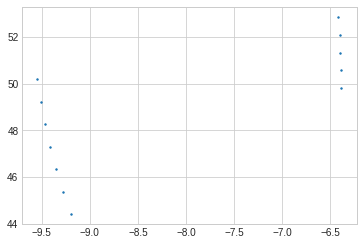

In [27]:
import numpy as np
prev_feat=np.empty([0,5])
for feat in lane_node_feats[:2]:
    prev_feat=np.r_[prev_feat,feat]
idx=-10
import matplotlib.pyplot as plt
x=prev_feat[:,0]
y=prev_feat[:,1]
plt.scatter(x,y,s=2)